In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
from tqdm import tqdm
import zipfile

import keras
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate, BatchNormalization, Activation, ZeroPadding2D, concatenate
from keras.backend import random_normal,ones_like,zeros_like,mean, get_session
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from keras.initializers import TruncatedNormal
from keras.callbacks import LearningRateScheduler, EarlyStopping, History
from PIL import Image
import warnings
import time
from glob import glob
import datetime
import seaborn as sns
import xml.etree.ElementTree as ET 

import matplotlib.pyplot as plt
%matplotlib inline

## Step 1 - Introduction
In this project we attempt to use a generative adversarial network (GAN) to create images of dogs without any ground truth data from which to predict.  A GAN is a type of deep learning network which generates data containing similar features as the input data and it is made up of two networks which are trained together.  The first of these networks is the Generator which, given random values as input, generates data with the same structure as the training data.  The second network is the Discriminator which, given data from both the training and generated data, attempts to classify the observations into either 'training' or 'generated'.  Both these networks are trained simultaniously where, here, the Generator attempts to create images which the Discriminator will misclassify as 'training' or 'real' dog images and the discriminator attempts to properly classify each image it is given. 
<br />

### The scoring would have been done via pre-trained neural networks, but the Kaggle competition is now closed.  Because of this, I have chosen to first print out another, top scoring notebooks' results and examples to compare my own model architecture outputs to.  More details on this are recorded above said comparison model below.
<br />

The images we are given are from the Stanford Dogs dataset which contains 20,580 images of 120 different breeds of dogs.  The annotations include the class labels (breeds) as well as bounding boxes for the images.  These bounding boxes make each image into size (64, 64, 3) - i.e. a 64x64 pixel image with RGB coloring.  

Something important to note for this project is that almost all of the top scoring notebooks for the competition used almost identical code.  From reading through many of the top projects it becomes clear that there is a reason for this.  All of these top scoring notebooks utilized a method that seemed to have come from Chris Deotte's Dog Memorizer GAN notebook (https://www.kaggle.com/code/cdeotte/dog-memorizer-gan/notebook) in which he shows a way of having the Generator split up in to two types; a Memorizer Generator and a Generalizing Generator.  The Memorizing Generator attempts to memorize all the images from the training set, while the Generalizor Generator is used in an attempt to 'generalize' the coached images in to being more than just a re-print of the memorized images.  With this said, it is clear that if the Memorizer Generator is relied upon heavily enough it would simply be a case of the model memorizing then regurgitating the images in the training set which seems to defeat the whole purpose of the competition.  Despite this, if the Generalizor Generator is used, it does seem possible to achieve a sense of 'newness' from the images despite them being clearly formed from part of the memorized training images.  This is quite an interesting concept to me, and seeing as how this notebook won a medal for the competition it was clearly an allowed submission despite the possible issues of memorizing the training data.  
<br />

Something other than the model that was clearly copied across most of the top submissions was the way of reading in the data.  Since this project of ours is concerned about GANs and modeling I have chosen to keep the oft-used reading in strategy of all of these top notebooks here.  

examples of notebooks which use this method (in addition to Chris Deottes):   
https://www.kaggle.com/code/hirune924/public-lb-5-17518-solution-memorizer-cgan  
https://www.kaggle.com/code/a11rand0m/memorizer-v1  
https://www.kaggle.com/code/ms2019/memorizer-cgan-pytorch-version  
https://www.kaggle.com/code/roydatascience/introduction-to-generative-adversarial-networks  
etc.


In [2]:
rootpath = "../input/generative-dog-images/" #set path to ROOT

In [3]:
#unzip files all-dogs
with zipfile.ZipFile(rootpath + 'all-dogs.zip', 'r') as zip_ref:
    zip_ref.extractall() #now just in 'all-dogs', working dir
#unzip files Annotation
with zipfile.ZipFile(rootpath + 'Annotation.zip', 'r') as zip_ref:
    zip_ref.extractall() # now just in 'Annotation', working dir

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


0
1000
2000
3000
4000
5000
6000
7000
8000
9000


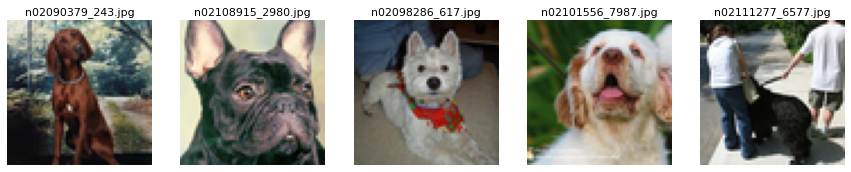

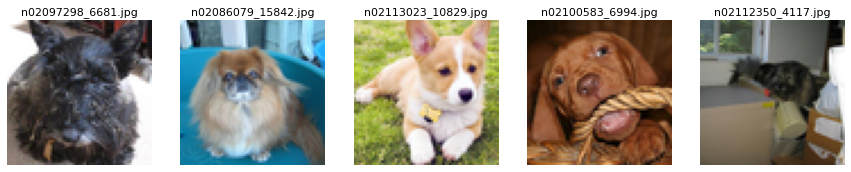

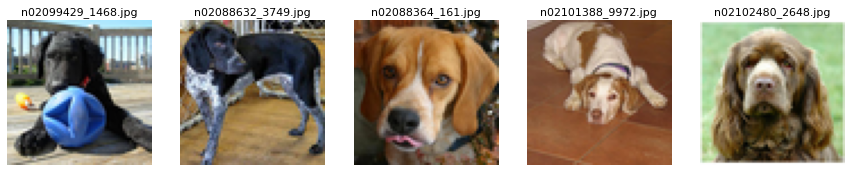

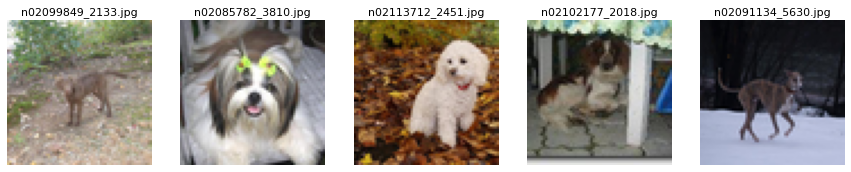

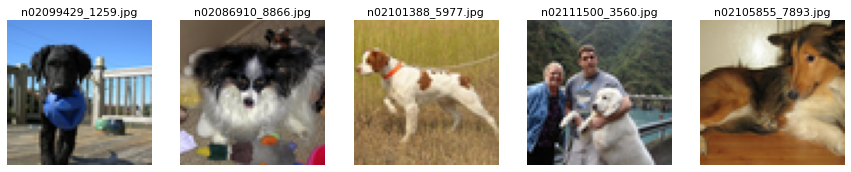

In [4]:
ComputeLB = False
DogsOnly = False


IMAGES = os.listdir('all-dogs')
breeds = os.listdir('Annotation') 

idxIn = 0; namesIn = []
imagesIn = np.zeros((25000,64,64,3))

# CROP WITH BOUNDING BOXES TO GET DOGS ONLY
# https://www.kaggle.com/paulorzp/show-annotations-and-breeds
if DogsOnly:
    for breed in breeds:
        for dog in os.listdir('Annotation/'+breed):
            try: img = Image.open('all-dogs/'+dog+'.jpg') 
            except: continue           
            tree = ET.parse('Annotation/'+breed+'/'+dog)
            root = tree.getroot()
            objects = root.findall('object')
            for o in objects:
                bndbox = o.find('bndbox') 
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                w = np.min((xmax - xmin, ymax - ymin))
                img2 = img.crop((xmin, ymin, xmin+w, ymin+w))
                img2 = img2.resize((64,64), Image.ANTIALIAS)
                imagesIn[idxIn,:,:,:] = np.asarray(img2)
                #if idxIn%1000==0: print(idxIn)
                namesIn.append(breed)
                idxIn += 1
    idx = np.arange(idxIn)
    np.random.shuffle(idx)
    imagesIn = imagesIn[idx,:,:,:]
    namesIn = np.array(namesIn)[idx]
    
# RANDOMLY CROP FULL IMAGES
else:
    x = np.random.choice(np.arange(20579),10000)
    for k in range(len(x)):
        img = Image.open('all-dogs/' + IMAGES[x[k]])
        w = img.size[0]
        h = img.size[1]
        sz = np.min((w,h))
        a=0; b=0
        if w<h: b = (h-sz)//2
        else: a = (w-sz)//2
        img = img.crop((0+a, 0+b, sz+a, sz+b))  
        img = img.resize((64,64), Image.ANTIALIAS)   
        imagesIn[idxIn,:,:,:] = np.asarray(img)
        namesIn.append(IMAGES[x[k]])
        if idxIn%1000==0: print(idxIn)
        idxIn += 1
    
# DISPLAY CROPPED IMAGES
x = np.random.randint(0,idxIn,25)
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        plt.subplot(1,5,j+1)
        img = Image.fromarray( imagesIn[x[k*5+j],:,:,:].astype('uint8') )
        plt.axis('off')
        if not DogsOnly: plt.title(namesIn[x[k*5+j]],fontsize=11)
        else: plt.title(namesIn[x[k*5+j]].split('-')[1],fontsize=11)
        plt.imshow(img)
    plt.show()

Since we took the way the input was generated, it in a sense decides for us how we will structure our discriminator and generators.  At least in the sense of how it'll be input and called (to an extent).  That leaves us with deciding on the bulk of the architecture past this, and the associated hyperparamters, which is exactly what our project is meant to be about.  
First we'll take one of the top scoring notebooks' models to get some results to compare our own to.  Since we can no longer submit the notebooks for a score, this seemed the best way to compare our model architecture.  This particular model was Chris Deottes' original formulation and seemed the best thing to compare my work to, since his was the notebook that won a metal in this competition and clearly inspired many, many others' submissions.

## A top scoring models' approach: 
##### https://www.kaggle.com/code/cdeotte/dog-memorizer-gan/notebook
This seems to be the person that set off the craze for the memorizer GAN notebooks in this kaggle competition.  
Their work is kept here so as to have something to directly compare our results to, since the kaggle competition is closed to new submissions.

In [18]:
# # BUILD DISCRIMINATIVE NETWORK
# dog = Input((12288,))
# dogName = Input((10000,))
# x = Dense(12288, activation='sigmoid')(dogName) 
# x = Reshape((2,12288,1))(concatenate([dog,x]))
# x = Conv2D(1,(2,1),use_bias=False,name='conv')(x)
# discriminated = Flatten()(x)

# # COMPILE
# discriminator = Model([dog,dogName], discriminated)
# discriminator.get_layer('conv').trainable = False
# discriminator.get_layer('conv').set_weights([np.array([[[[-1.0 ]]],[[[1.0]]]])])
# discriminator.compile(optimizer='adam', loss='binary_crossentropy')

# # DISPLAY ARCHITECTURE
# discriminator.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 10000)]      0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 12288)]      0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 12288)        122892288   input_8[0][0]                    
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 24576)        0           input_7[0][0]                    
                                                                 dense_3[0][0]              

In [19]:
# # TRAINING DATA
# train_y = (imagesIn[:10000,:,:,:]/255.).reshape((-1,12288))
# train_X = np.zeros((10000,10000))
# for i in range(10000): train_X[i,i] = 1
# zeros = np.zeros((10000,12288))

# # TRAIN NETWORK
# lr = 0.5
# for k in range(5):
#     annealer = LearningRateScheduler(lambda x: lr)
#     h = discriminator.fit([zeros,train_X], train_y, epochs = 10, batch_size=126, callbacks=[annealer], verbose=0)
#     print('Epoch',(k+1)*10,'/30 - loss =',h.history['loss'][-1] )
#     if h.history['loss'][-1]<0.533: lr = 0.1

Epoch 10 /30 - loss = 0.5408005714416504
Epoch 20 /30 - loss = 0.5382223129272461
Epoch 30 /30 - loss = 0.5379286408424377
Epoch 40 /30 - loss = 0.5378394722938538
Epoch 50 /30 - loss = 0.5378002524375916


In [20]:
# # DELETE TRAINING IMAGES
# del train_X, train_y, imagesIn

Discriminator Recalls from Memory Dogs


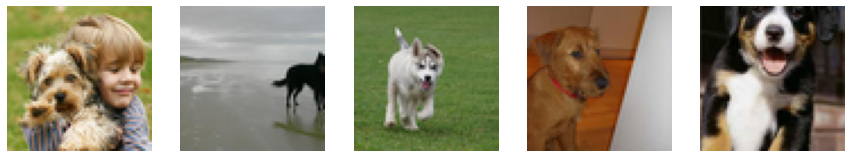

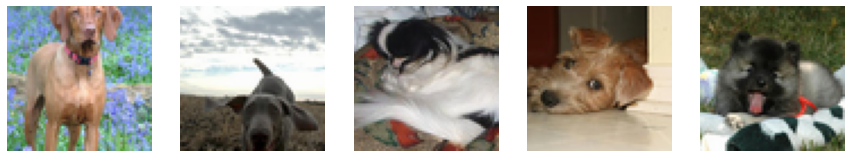

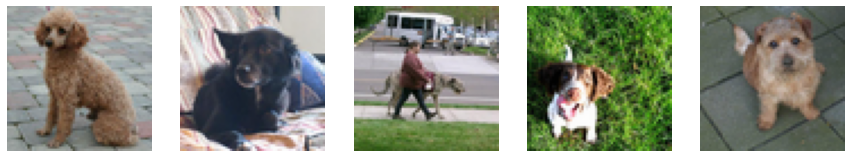

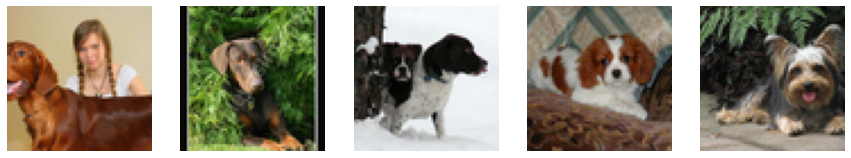

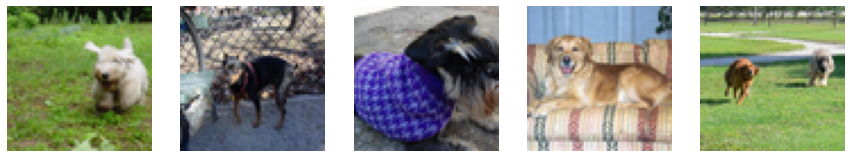

In [21]:
# print('Discriminator Recalls from Memory Dogs')    
# for k in range(5):
#     plt.figure(figsize=(15,3))
#     for j in range(5):
#         xx = np.zeros((10000))
#         xx[np.random.randint(10000)] = 1
#         plt.subplot(1,5,j+1)
#         img = discriminator.predict([zeros[0,:].reshape((-1,12288)),xx.reshape((-1,10000))]).reshape((-1,64,64,3))
#         img = Image.fromarray( (255*img).astype('uint8').reshape((64,64,3)))
#         plt.axis('off')
#         plt.imshow(img)
#     plt.show()

In [22]:
# # BUILD GENERATOR NETWORK
# BadMemory = True

# if BadMemory:
#     seed = Input((10000,))
#     x = Dense(2048, activation='elu')(seed)
#     x = Reshape((8,8,32))(x)
#     x = Conv2D(128, (3, 3), activation='elu', padding='same')(x)
#     x = UpSampling2D((2, 2))(x)
#     x = Conv2D(64, (3, 3), activation='elu', padding='same')(x)
#     x = UpSampling2D((2, 2))(x)
#     x = Conv2D(32, (3, 3), activation='elu', padding='same')(x)
#     x = UpSampling2D((2, 2))(x)
#     x = Conv2D(3, (3, 3), activation='linear', padding='same')(x)
#     generated = Flatten()(x)
# else:
#     seed = Input((10000,))
#     generated = Dense(12288, activation='linear')(seed)

# # COMPILE
# generator = Model(seed, [generated,Reshape((10000,))(seed)])

# # DISPLAY ARCHITECTURE
# generator.summary()


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 10000)]      0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 2048)         20482048    input_9[0][0]                    
__________________________________________________________________________________________________
reshape_5 (Reshape)             (None, 8, 8, 32)     0           dense_4[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 8, 8, 128)    36992       reshape_5[0][0]                  
____________________________________________________________________________________________

In [27]:
# # BUILD GENERATIVE ADVERSARIAL NETWORK
# discriminator.trainable=False    
# gan_input = Input(shape=(10000,))
# x = generator(gan_input)
# gan_output = discriminator(x)

# # COMPILE GAN
# gan = Model(gan_input, gan_output)
# gan.get_layer('model').get_layer('conv').set_weights([np.array([[[[-1 ]]],[[[255.]]]])])
# gan.compile(optimizer=Adam(5), loss='mean_squared_error')

# # DISPLAY ARCHITECTURE
# gan.summary()

In [ ]:
# # TRAINING DATA
# train = np.zeros((10000,10000))
# for i in range(10000): train[i,i] = 1
# zeros = np.zeros((10000,12288))

# # TRAIN NETWORKS
# ep = 1; it = 9
# if BadMemory: lr = 0.005
# else: lr = 5.
    
# for k in range(it):  

#     # BEGIN DISCRIMINATOR COACHES GENERATOR
#     annealer = LearningRateScheduler(lambda x: lr)
#     h = gan.fit(train, zeros, epochs = ep, batch_size=256, callbacks=[annealer], verbose=0)

#     # DISPLAY GENERATOR LEARNING PROGRESS 
#     print('Epoch',(k+1),'/'+str(it)+' - loss =',h.history['loss'][-1] )
#     plt.figure(figsize=(15,3))
#     for j in range(5):
#         xx = np.zeros((10000))
#         xx[np.random.randint(10000)] = 1
#         plt.subplot(1,5,j+1)
#         img = generator.predict(xx.reshape((-1,10000)))[0].reshape((-1,64,64,3))
#         img = Image.fromarray( (img).astype('uint8').reshape((64,64,3)))
#         plt.axis('off')
#         plt.imshow(img)
#     plt.show()  
            
#     # ADJUST LEARNING RATES
#     if BadMemory:
#         ep *= 2
#         if ep>=32: lr = 0.001
#         if ep>256: ep = 256
#     else:
#         if h.history['loss'][-1] < 25: lr = 1.
#         if h.history['loss'][-1] < 1.5: lr = 0.5

## Our Work Now  
Now that we have something we can actually comapare our outputs to, we can build our own model architecture and perform our own hyperparameter tuning as is the focus of this project.  
We will of course use a similar method as done above, since literally every top submission directly copied the above with their only real work being to decrease the amount of 'randomness' that the Generalizer Generator introduced.  
We will begin by trying a few different architectures / layer combinations with a memorizer GAN.
<br />
First set up the Discriminator 

In [28]:
# BUILD DISCRIMINATIVE NETWORK
dog = Input((12288,)) #12288 = 64 * 192
dogName = Input((10000,))
x = Dense(12288, activation='sigmoid')(dogName) 
x = Reshape((2,12288,1))(concatenate([dog,x]))
x = Conv2D(1,(2,1),use_bias=False,name='conv')(x)
discriminated = Flatten()(x)

# COMPILE
discriminator = Model([dog,dogName], discriminated)
discriminator.get_layer('conv').trainable = False
discriminator.get_layer('conv').set_weights([np.array([[[[-1.0 ]]],[[[1.0]]]])])
discriminator.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy') #set a specific learning rate, leave moment estimate decay for now

# DISPLAY ARCHITECTURE
discriminator.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 10000)]      0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 12288)]      0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 12288)        122892288   input_14[0][0]                   
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 24576)        0           input_13[0][0]                   
                                                                 dense_5[0][0]              

Training Discriminator, this is the part that makes it a 'memorizer' GAN as in a 'normal' GAN the discriminator is trained with the Generator

In [29]:
# TRAINING DATA, same as above
train_y = (imagesIn[:10000,:,:,:]/255.).reshape((-1,12288))
train_X = np.zeros((10000,10000))
for i in range(10000): train_X[i,i] = 1
zeros = np.zeros((10000,12288))

#train discrim network
#reduce batch size, remove the callback to the LR scheduler as we'll try to get the best LR ourselves
history = discriminator.fit([zeros,train_X], train_y, epochs = 10, batch_size=128, verbose=1)

Epoch 1/10
79/79 [==============================] - 3s 28ms/step - loss: 0.6930
Epoch 2/10
79/79 [==============================] - 2s 26ms/step - loss: 0.6926
Epoch 3/10
79/79 [==============================] - 2s 25ms/step - loss: 0.6922
Epoch 4/10
79/79 [==============================] - 2s 25ms/step - loss: 0.6918
Epoch 5/10
79/79 [==============================] - 2s 25ms/step - loss: 0.6914
Epoch 6/10
79/79 [==============================] - 2s 26ms/step - loss: 0.6910
Epoch 7/10
79/79 [==============================] - 2s 26ms/step - loss: 0.6907
Epoch 8/10
79/79 [==============================] - 2s 25ms/step - loss: 0.6903
Epoch 9/10
79/79 [==============================] - 2s 25ms/step - loss: 0.6900
Epoch 10/10
79/79 [==============================] - 2s 25ms/step - loss: 0.6897


Text(0, 0.5, 'Loss Value')

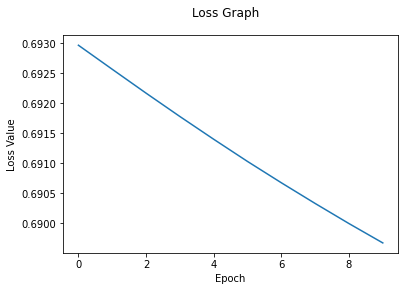

In [30]:
fig = plt.figure()
plt.plot(history.epoch, history.history['loss'], label = 'Training Loss')
fig.suptitle("Loss Graph")
plt.xlabel("Epoch")
plt.ylabel("Loss Value")

Loss is linear, seems odd.  Perhaps it just needs more epochs and the learning rate is fine, let's test that.  Add an early stopping procedure.

In [5]:
callbacks = [EarlyStopping(monitor = 'loss', patience = 2)] #early stopping based on the loss if loss increases 2x in a row

In [6]:
# BUILD DISCRIMINATIVE NETWORK
dog = Input((12288,)) #12288 = 64 * 192
dogName = Input((10000,))
x = Dense(12288, activation='sigmoid')(dogName) 
x = Reshape((2,12288,1))(concatenate([dog,x]))
x = Conv2D(1,(2,1),use_bias=False,name='conv')(x)
discriminated = Flatten()(x)

# COMPILE
discriminator = Model([dog,dogName], discriminated)
discriminator.get_layer('conv').trainable = False
discriminator.get_layer('conv').set_weights([np.array([[[[-1.0 ]]],[[[1.0]]]])])
discriminator.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy') #set a specific learning rate, leave moment estimate decay for now

# DISPLAY ARCHITECTURE
discriminator.summary()

2022-09-26 19:50:18.570371: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-26 19:50:18.669113: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-26 19:50:18.670068: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 10000)]      0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 12288)]      0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 12288)        122892288   input_2[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 24576)        0           input_1[0][0]                    
                                                                 dense[0][0]                  

2022-09-26 19:50:18.672173: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-26 19:50:18.672522: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-26 19:50:18.673239: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-26 19:50:18.673931: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [35]:
# # TRAINING DATA, same as above
# train_y = (imagesIn[:10000,:,:,:]/255.).reshape((-1,12288))
# train_X = np.zeros((10000,10000))
# for i in range(10000): train_X[i,i] = 1
# zeros = np.zeros((10000,12288))

# #train discrim network
# #reduce batch size, remove the callback to the LR scheduler as we'll try to get the best LR ourselves
# history = discriminator.fit([zeros,train_X], train_y, epochs = 50, batch_size=128, verbose=1,callbacks= callbacks)

In [36]:
# fig = plt.figure()
# plt.plot(history.epoch, history.history['loss'], label = 'Training Loss')
# fig.suptitle("Loss Graph")
# plt.xlabel("Epoch")
# plt.ylabel("Loss Value")

See similar results. Straight-ish line.  Lets try increasing the learning rate by quite a bit.

In [7]:
# BUILD DISCRIMINATIVE NETWORK
dog = Input((12288,)) #12288 = 64 * 192
dogName = Input((10000,))
x = Dense(12288, activation='sigmoid')(dogName) 
x = Reshape((2,12288,1))(concatenate([dog,x]))
x = Conv2D(1,(2,1),use_bias=False,name='conv')(x)
discriminated = Flatten()(x)

# COMPILE
discriminator = Model([dog,dogName], discriminated)
discriminator.get_layer('conv').trainable = False
discriminator.get_layer('conv').set_weights([np.array([[[[-1.0 ]]],[[[1.0]]]])])
discriminator.compile(optimizer=Adam(learning_rate=0.1), loss='binary_crossentropy') #set a specific learning rate, leave moment estimate decay for now

# DISPLAY ARCHITECTURE
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 10000)]      0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 12288)]      0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 12288)        122892288   input_4[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 24576)        0           input_3[0][0]                    
                                                                 dense_1[0][0]              

In [8]:
# TRAINING DATA, same as above
train_y = (imagesIn[:10000,:,:,:]/255.).reshape((-1,12288))
train_X = np.zeros((10000,10000))
for i in range(10000): train_X[i,i] = 1
zeros = np.zeros((10000,12288))

#train discrim network
#reduce batch size, remove the callback to the LR scheduler as we'll try to get the best LR ourselves
history = discriminator.fit([zeros,train_X], train_y, epochs = 30, batch_size=128, verbose=1, callbacks = callbacks)

2022-09-26 19:50:26.181935: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-09-26 19:50:28.528244: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


79/79 [==============================] - 9s 26ms/step - loss: 0.6839
Epoch 2/30
79/79 [==============================] - 2s 26ms/step - loss: 0.6755
Epoch 3/30
79/79 [==============================] - 2s 26ms/step - loss: 0.6639
Epoch 4/30
79/79 [==============================] - 2s 25ms/step - loss: 0.6509
Epoch 5/30
79/79 [==============================] - 2s 26ms/step - loss: 0.6380
Epoch 6/30
79/79 [==============================] - 2s 27ms/step - loss: 0.6256
Epoch 7/30
79/79 [==============================] - 2s 29ms/step - loss: 0.6142
Epoch 8/30
79/79 [==============================] - 2s 26ms/step - loss: 0.6040
Epoch 9/30
79/79 [==============================] - 2s 26ms/step - loss: 0.5950
Epoch 10/30
79/79 [==============================] - 2s 26ms/step - loss: 0.5870
Epoch 11/30
79/79 [==============================] - 2s 27ms/step - loss: 0.5802
Epoch 12/30
79/79 [==============================] - 2s 26ms/step - loss: 0.5743
Epoch 13/30
79/79 [=============================

Text(0, 0.5, 'Loss Value')

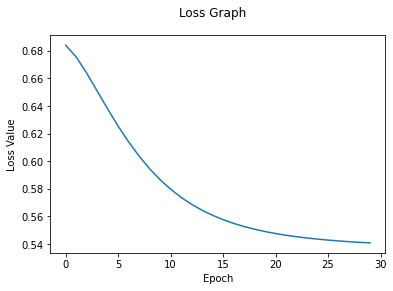

In [9]:
fig = plt.figure()
plt.plot(history.epoch, history.history['loss'], label = 'Training Loss')
fig.suptitle("Loss Graph")
plt.xlabel("Epoch")
plt.ylabel("Loss Value")

A much more reasonable learning rate. Looks good!  Now our descriminator is nicely trained so we delete the training images.

In [13]:
# del train_X, train_y, imagesIn

As in the original, we now build the Generator.  Since we always want the 'BadMemory' variable (as otherwise we'd just have a perfectly memorized training set) we discard the choice and keep only what we need below.

In [9]:
seed = Input((10000,))
generated = Dense(12288, activation='linear')(seed)

generator = Model(seed, [generated,Reshape((10000,))(seed)])

generator.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 10000)]      0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 12288)        122892288   input_5[0][0]                    
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 10000)        0           input_5[0][0]                    
Total params: 122,892,288
Trainable params: 122,892,288
Non-trainable params: 0
__________________________________________________________________________________________________


We now build the memorizer GAN as a whole.  This is where the rest of our hyperparameter tuning comes in to play.  
<br />

Coming back to this after having gone through many, many iterations of model weights and learning rates I have deleted quite a few and left only these below for illustrative purposes.  Values for the weights ranged from [-1],[1] to [-255],[255].  Values for the learning rates below ranged from 0.1 to 100.0  

#### Hparams below:
Weights are [01],[255], gan has lr = 1, fitting has lr = 1 

In [18]:
#keep this set to show in notebook!
discriminator.trainable=False    
gan_input = Input(shape=(10000,))
x = generator(gan_input)
gan_output = discriminator(x)

gan = Model(gan_input, gan_output)
gan.get_layer('model').get_layer('conv').set_weights([np.array([[[[-1 ]]],[[[255.]]]])])
gan.compile(optimizer=Adam(1), loss='mean_squared_error')

# DISPLAY ARCHITECTURE
gan.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 10000)]      0                                            
__________________________________________________________________________________________________
model_6 (Functional)            [(None, 12288), (Non 122892288   input_11[0][0]                   
__________________________________________________________________________________________________
model (Functional)              (None, 12288)        122892290   model_6[2][0]                    
                                                                 model_6[2][1]                    
Total params: 245,784,578
Trainable params: 122,892,288
Non-trainable params: 122,892,290
__________________________________________________________________________________________________


And finally we have our Discriminator coaching the Generator.  Here we can again do some hyperparameter tuning.

40/40 [==============================] - 2s 43ms/step - loss: 12443.0195
Epoch 10 /500 - loss = 12443.01953125


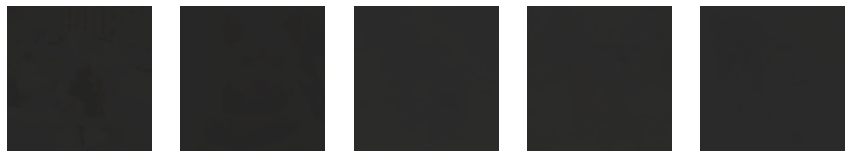

40/40 [==============================] - 2s 43ms/step - loss: 6492.9722
Epoch 20 /500 - loss = 6492.97216796875


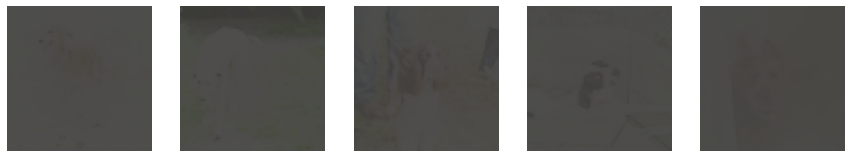

40/40 [==============================] - 2s 43ms/step - loss: 3909.7043
Epoch 30 /500 - loss = 3909.704345703125


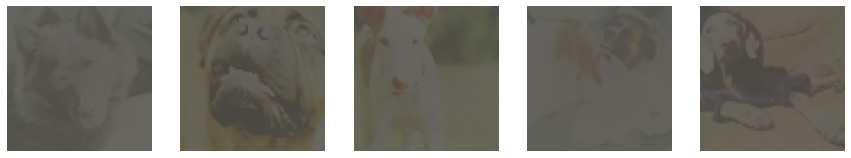

40/40 [==============================] - 2s 44ms/step - loss: 2826.7893
Epoch 40 /500 - loss = 2826.789306640625


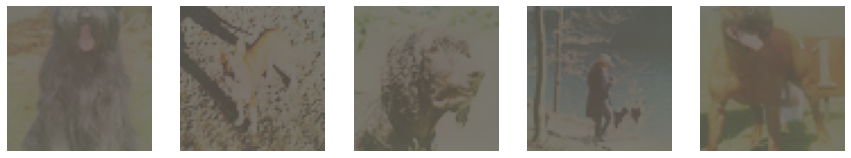

40/40 [==============================] - 2s 46ms/step - loss: 2258.4575
Epoch 50 /500 - loss = 2258.45751953125


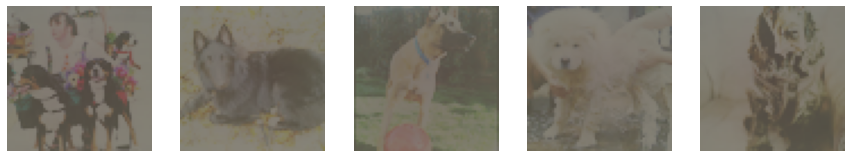

40/40 [==============================] - 2s 44ms/step - loss: 1862.9392
Epoch 60 /500 - loss = 1862.939208984375


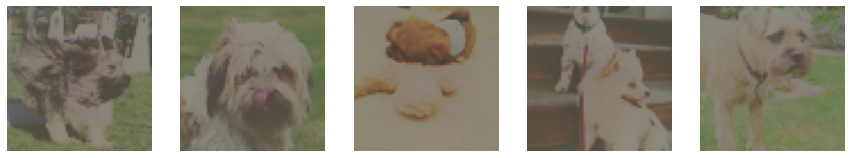

40/40 [==============================] - 2s 45ms/step - loss: 1545.4980
Epoch 70 /500 - loss = 1545.498046875


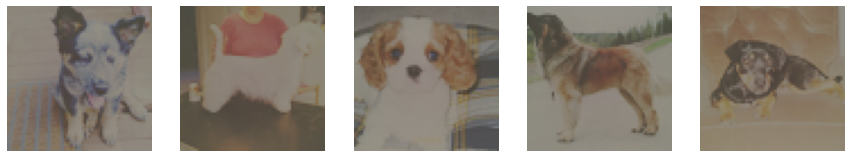

40/40 [==============================] - 2s 43ms/step - loss: 1281.4207
Epoch 80 /500 - loss = 1281.420654296875


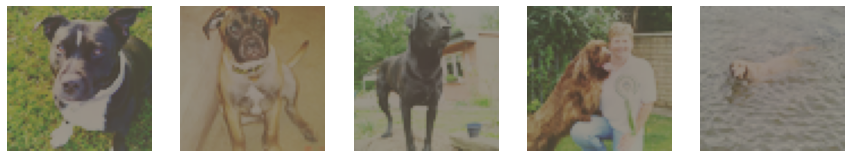

40/40 [==============================] - 2s 43ms/step - loss: 1059.6187
Epoch 90 /500 - loss = 1059.61865234375


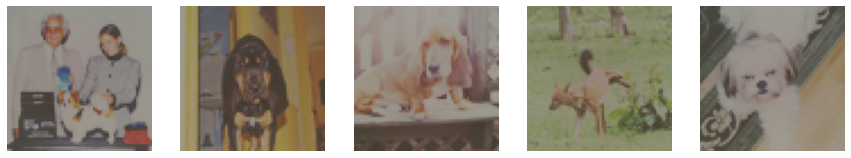

40/40 [==============================] - 2s 44ms/step - loss: 873.4423
Epoch 100 /500 - loss = 873.4423217773438


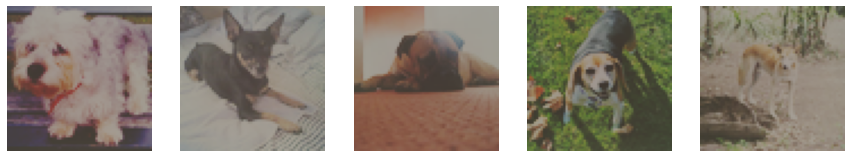

40/40 [==============================] - 2s 43ms/step - loss: 320.6882
Epoch 150 /500 - loss = 320.6882019042969
40/40 [==============================] - 2s 43ms/step - loss: 112.8826
Epoch 200 /500 - loss = 112.88262176513672
40/40 [==============================] - 2s 43ms/step - loss: 48.6981


In [ ]:
# TRAINING DATA
train = np.zeros((10000,10000))
for i in range(10000): train[i,i] = 1
zeros = np.zeros((10000,12288))

# TRAIN NETWORKS
lr = 1
for k in range(50):  

    # BEGIN DISCRIMINATOR COACHES GENERATOR, keep some of the printing. remove the adjustable lr so we can find the 'best' by look
    h = gan.fit(train, zeros, epochs = 1, batch_size=128, callbacks=callbacks, verbose=1)
    if (k<10)|(k%5==4):
        print('Epoch',(k+1)*10,'/500 - loss =',h.history['loss'][-1] )
        
    # DISPLAY GENERATOR LEARNING PROGRESS, kept from original, useful for illustrative purposes
    if k<10:        
        plt.figure(figsize=(15,3))
        for j in range(5):
            xx = np.zeros((10000))
            xx[np.random.randint(10000)] = 1
            plt.subplot(1,5,j+1)
            img = generator.predict(xx.reshape((-1,10000)))[0].reshape((-1,64,64,3))
            img = Image.fromarray( (img).astype('uint8').reshape((64,64,3)))
            plt.axis('off')
            plt.imshow(img)
        plt.show()  

#### Hparams below:  
Weights are [-1],[1], lr for optimizer is 1, lr for training is kept at 1

In [19]:
#keep this set to show in notebook!
discriminator.trainable=False    
gan_input = Input(shape=(10000,))
x = generator(gan_input)
gan_output = discriminator(x)

gan = Model(gan_input, gan_output)
gan.get_layer('model').get_layer('conv').set_weights([np.array([[[[-1.0 ]]],[[[1.0]]]])])
gan.compile(optimizer=Adam(1), loss='cosine_similarity')

# DISPLAY ARCHITECTURE
gan.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 10000)]      0                                            
__________________________________________________________________________________________________
model_6 (Functional)            [(None, 12288), (Non 122892288   input_12[0][0]                   
__________________________________________________________________________________________________
model (Functional)              (None, 12288)        122892290   model_6[3][0]                    
                                                                 model_6[3][1]                    
Total params: 245,784,578
Trainable params: 122,892,288
Non-trainable params: 122,892,290
__________________________________________________________________________________________________


79/79 [==============================] - 2s 27ms/step - loss: 0.0733
Epoch 10 /500 - loss = 0.07327727973461151


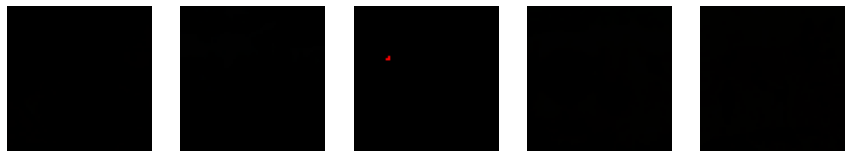

79/79 [==============================] - 2s 27ms/step - loss: 0.2066
Epoch 20 /500 - loss = 0.20655451714992523


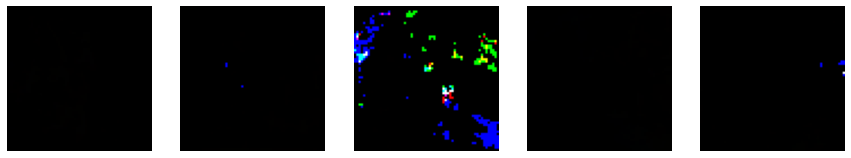

79/79 [==============================] - 2s 27ms/step - loss: 1.2560
Epoch 30 /500 - loss = 1.256047010421753


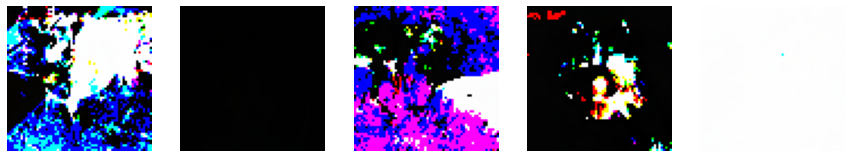

79/79 [==============================] - 2s 27ms/step - loss: 7.2653
Epoch 40 /500 - loss = 7.265307903289795


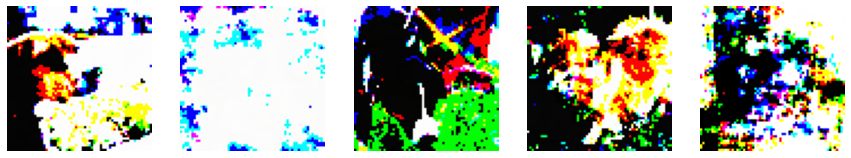

79/79 [==============================] - 2s 27ms/step - loss: 21.5353
Epoch 50 /500 - loss = 21.535324096679688


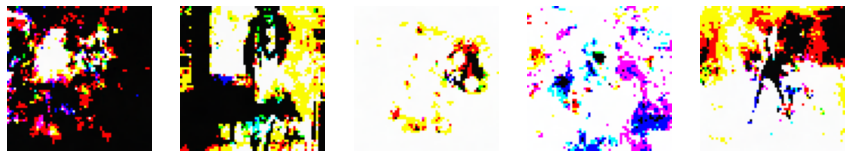

79/79 [==============================] - 2s 28ms/step - loss: 28.9831
Epoch 60 /500 - loss = 28.983118057250977


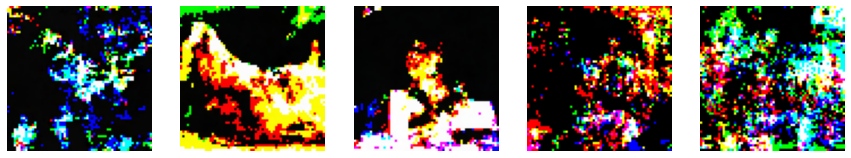

79/79 [==============================] - 2s 27ms/step - loss: 23.5016
Epoch 70 /500 - loss = 23.501575469970703


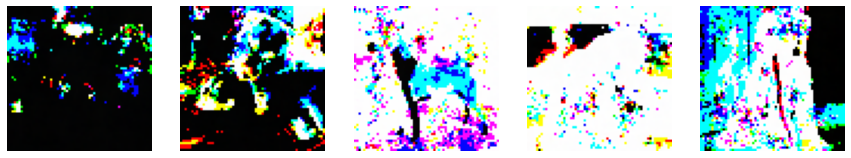

79/79 [==============================] - 2s 28ms/step - loss: 15.5428
Epoch 80 /500 - loss = 15.542792320251465


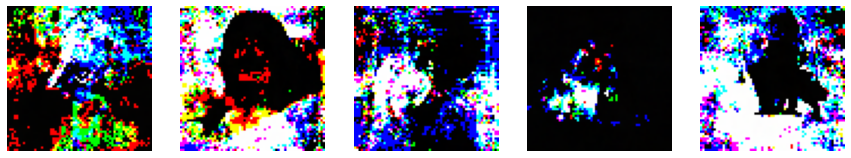

79/79 [==============================] - 2s 27ms/step - loss: 10.2227
Epoch 90 /500 - loss = 10.222728729248047


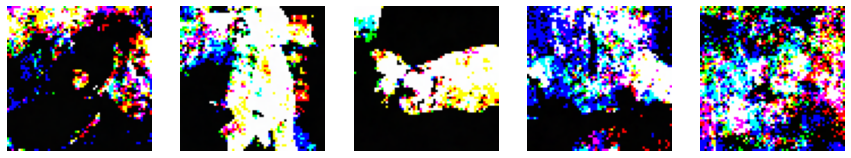

79/79 [==============================] - 2s 28ms/step - loss: 7.3905
Epoch 100 /500 - loss = 7.390506267547607


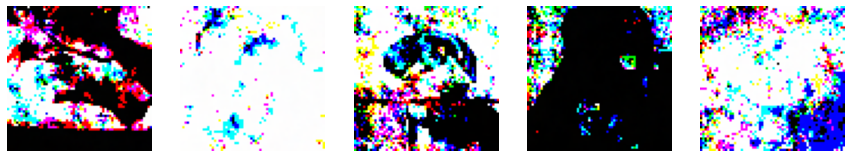

79/79 [==============================] - 2s 28ms/step - loss: 9.4077
Epoch 150 /500 - loss = 9.40772819519043
79/79 [==============================] - 2s 27ms/step - loss: 18.3852
Epoch 200 /500 - loss = 18.385194778442383
79/79 [==============================] - 2s 27ms/step - loss: 12.9219
Epoch 250 /500 - loss = 12.921942710876465
79/79 [==============================] - 2s 27ms/step - loss: 10.2442
Epoch 300 /500 - loss = 10.244186401367188
79/79 [==============================] - 2s 27ms/step - loss: 10.4916


In [ ]:
# TRAINING DATA
train = np.zeros((10000,10000))
for i in range(10000): train[i,i] = 1
zeros = np.zeros((10000,12288))

# TRAIN NETWORKS
lr = 1
for k in range(50):  

    # BEGIN DISCRIMINATOR COACHES GENERATOR, keep some of the printing. remove the adjustable lr so we can find the 'best' by look
    h = gan.fit(train, zeros, epochs = 1, batch_size=128, callbacks=callbacks, verbose=1)
    if (k<10)|(k%5==4):
        print('Epoch',(k+1)*10,'/500 - loss =',h.history['loss'][-1] )
        
    # DISPLAY GENERATOR LEARNING PROGRESS, kept from original, useful for illustrative purposes
    if k<10:        
        plt.figure(figsize=(15,3))
        for j in range(5):
            xx = np.zeros((10000))
            xx[np.random.randint(10000)] = 1
            plt.subplot(1,5,j+1)
            img = generator.predict(xx.reshape((-1,10000)))[0].reshape((-1,64,64,3))
            img = Image.fromarray( (img).astype('uint8').reshape((64,64,3)))
            plt.axis('off')
            plt.imshow(img)
        plt.show()  

#### Hparams below:  
Weights are [-1],[255], lr for optimizer is 5, lr for training is kept at 5

In [14]:
#keep this set to show in notebook!
discriminator.trainable=False    
gan_input = Input(shape=(10000,))
x = generator(gan_input)
gan_output = discriminator(x)

gan = Model(gan_input, gan_output)
gan.get_layer('model_1').get_layer('conv').set_weights([np.array([[[[-1.0 ]]],[[[255.0]]]])]) 
gan.compile(optimizer=Adam(5), loss='mean_squared_error')

# DISPLAY ARCHITECTURE
gan.summary()

#the model required for gan.get)layer() can be found by commenting out lines 8 and 9, seeing the last model (functional)'s name

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 10000)]      0                                            
__________________________________________________________________________________________________
model_2 (Functional)            [(None, 12288), (Non 122892288   input_8[0][0]                    
__________________________________________________________________________________________________
model_1 (Functional)            (None, 12288)        122892290   model_2[2][0]                    
                                                                 model_2[2][1]                    
Total params: 245,784,578
Trainable params: 122,892,288
Non-trainable params: 122,892,290
__________________________________________________________________________________________________


79/79 [==============================] - 3s 28ms/step - loss: 205.6979
Epoch 10 /500 - loss = 205.69790649414062


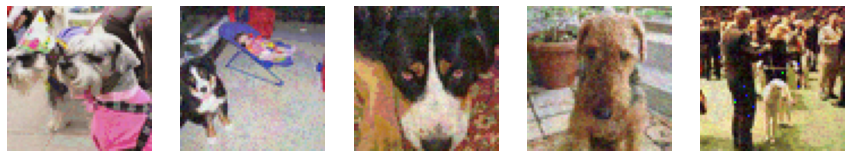

79/79 [==============================] - 2s 28ms/step - loss: 183.2984
Epoch 20 /500 - loss = 183.29844665527344


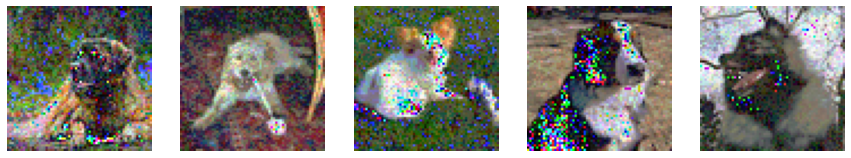

79/79 [==============================] - 2s 27ms/step - loss: 641.2717
Epoch 30 /500 - loss = 641.271728515625


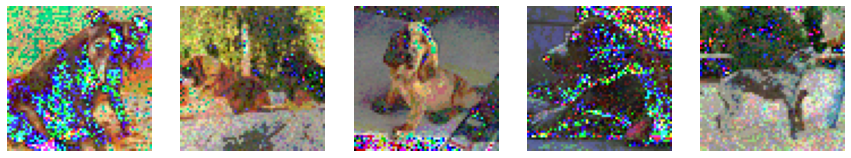

79/79 [==============================] - 2s 29ms/step - loss: 617.5104
Epoch 40 /500 - loss = 617.5103759765625


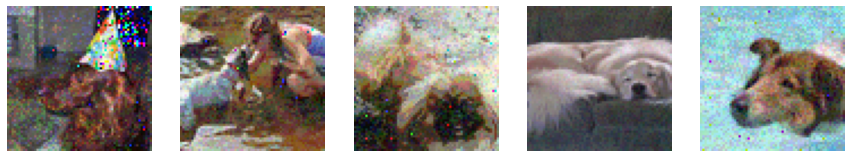

79/79 [==============================] - 2s 29ms/step - loss: 432.1226
Epoch 50 /500 - loss = 432.12255859375


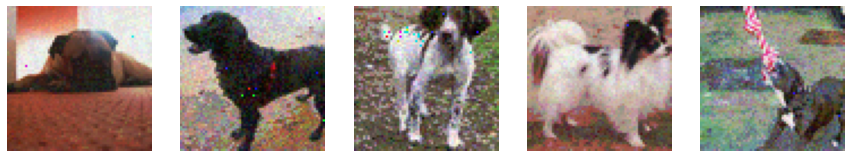

79/79 [==============================] - 2s 28ms/step - loss: 359.0332
Epoch 60 /500 - loss = 359.0331726074219


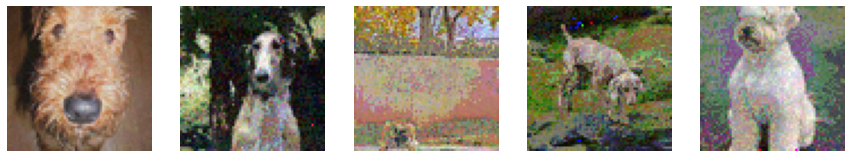

79/79 [==============================] - 2s 27ms/step - loss: 346.3304
Epoch 70 /500 - loss = 346.3304138183594


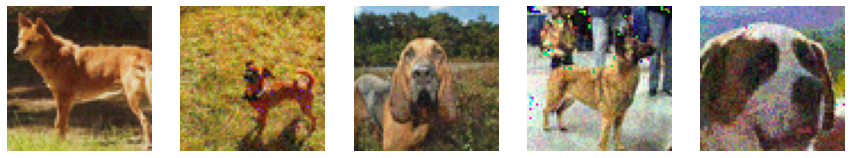

In [15]:
# TRAINING DATA
train = np.zeros((10000,10000))
for i in range(10000): train[i,i] = 1
zeros = np.zeros((10000,12288))

# TRAIN NETWORKS
lr = 5
for k in range(7):  

    # BEGIN DISCRIMINATOR COACHES GENERATOR, keep some of the printing. remove the adjustable lr so we can find the 'best' by look
    h = gan.fit(train, zeros, epochs = 1, batch_size=128, callbacks=callbacks, verbose=1)
    if (k<10)|(k%5==4):
        print('Epoch',(k+1)*10,'/500 - loss =',h.history['loss'][-1] )
        
    # DISPLAY GENERATOR LEARNING PROGRESS, kept from original, useful for illustrative purposes
    if k<10:        
        plt.figure(figsize=(15,3))
        for j in range(5):
            xx = np.zeros((10000))
            xx[np.random.randint(10000)] = 1
            plt.subplot(1,5,j+1)
            img = generator.predict(xx.reshape((-1,10000)))[0].reshape((-1,64,64,3))
            img = Image.fromarray( (img).astype('uint8').reshape((64,64,3)))
            plt.axis('off')
            plt.imshow(img)
        plt.show()  

Of the trials that were kept in the notebook we can see the following:  
<br />

|Weight1|Weight2|Adam LR|Result|
|---|---|---|---|
|-1|1|1|Bad, Grainy, Dark|
|-1|255|5|Grainy, 'Bouncing' (LR too high)|
|-1|255|1|Bright, Consistent Learning|

Because of this we select the [-1],[255],1 (W1, W2, LR) approach for our final models' hyperparameters.

## Results and Conclusions  
While the remaining architectures tested above contain only the 'default' memorizer GAN architecture, this is not for lack of trying.  **Adding in additional Dense layers was attempted** to varying degrees of success.  But at the end of the day, nothing could beat the architecture that was in the original notebook.  There were some improvements to be made via the learning rates which were kept in the notebook.  
The first of these came from optimizing the learning rate for the Discriminator.  In the original notebook the learning rate produced a loss curve that was just a straight line.  Increasing the number of epochs showed that the learning rate in no way formed an 'optimal' loss curve.  By increasing the learning rate (and keeping the number of epochs increased so as to see our results better) we ended up with a nice looking loss curve for our Discriminator.  
After the **Discriminator's LR was optimized we went on to change the architecture** (while keeping the LR and weights static at the 'default') by adding in Dense layers and attempting to fit and produce our images.  As mentioned before, these results varied but overall were at best comparable to not having the additional layers, but added on additional training time.  As such they were removed in the end and the focus went towards optimizing the learning rates for the 'default' architecture.  
Additionally, a **few different loss functions were attempted**.  In the end, the best success was found with mean squared error, but there were some interesting results with using a cosine similarity.
One thing that was relatively surprising was that the batch size had to be decreased because it continuously broke the Kaggle notebook if it was kept at the default.  This didn't take much tuning but rather was cut in half, but it was changed and as such is mentioned here.  Other than this, **various different weights and learning rates were tested**.  The weights varied from [[-255],[-255] up to [255],[255]] (inclusive).  The learning rates went from 0.1 up to 100.0.  While not every possible combination was attempted (as that would take forever) the best results were found when the weights were set to [-1],[255] and the learning rate set to a constant 1.  Varying the learning rate directly by epoch, such as what was done in the original notebook, had some success but it ended up being better to allow Adam to adaptively change the learning rates as it was made to do.  Some of the outputs from three of the hyperparameter combinations are kept above and it can be seen that the best does come from the aforementioned combination.  The 'brightness' of the images continues to decrease as the number of iterations continues and we end up with slightly varied versions of the original training images which will, of course, score highly since we are only mutating original images rather than generating completely new ones.  The advantage of a 'memorizer GAN' is clear from this since it was so simple to create and optimize.  The downside is of course that we have to consider if these 'new' images are truly 'new'.  Sure they are mutated in some ways, but at the end of the day a single hyperparameter is all that keeps us from literally just regurgitating the originally memorized images.  
While I was quite interested in the concept of a memorizer GAN when I was getting in to this project and reading through the top scoring notebooks, I believe that at the end of this that I have decided that they are not all that impressive.  The mutations were minor unless you were willing to sacrifice a lot of 'score', and if that was the case then why not stick to a 'traditional' GAN and get truly new images in which you can improve the model bit by bit?

Below is another small class that was made in the original notebook to show the effects of the two generators.  By adjusting the amount of memorized vs. generalized data to come through we can adjust our picture outputs.  I've added a small parameter called 'real' to adjust the amount of trained/memorized data is allowed through.  I've shown two examples of the extremes, one where it's nearly a purely memorized image first and secondly where it's just garbled noise. This is to further illustrate my point above, that at the end of the day a memorizer GAN is not truly making new images and that more traditional GANs are superior.

In [21]:
class DogGenerator:
    index = 0   
    def getDog(self,seed, real = 0.7):
        xx = np.zeros((10000))
        xx[self.index] = real
        xx[np.random.randint(10000)] = 1 - real
        img = generator.predict(xx.reshape((-1,10000)))[0].reshape((64,64,3))
        self.index = (self.index+1)%10000
        return Image.fromarray( img.astype('uint8') ) 

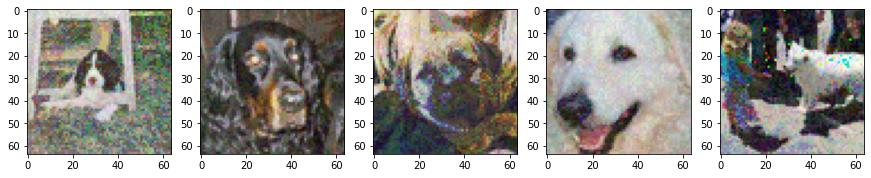

In [22]:
fig, axs = plt.subplots(1,5, figsize = (15,20))
d = DogGenerator()
for k in range(5):
    axs[k] = axs[k].imshow(d.getDog(np.random.normal(0,1,100), real = 0.01))

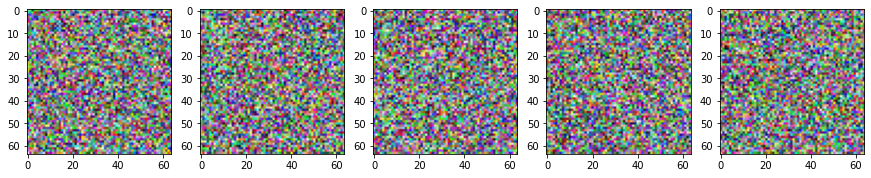

In [23]:
fig, axs = plt.subplots(1,5, figsize = (15,20))
d = DogGenerator()
for k in range(5):
    axs[k] = axs[k].imshow(d.getDog(np.random.normal(0,1,100), real = 99.9))